[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anacs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anacs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anacs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing techniques...
Generating text embeddings...


Batches:   0%|          | 0/58 [00:00<?, ?it/s]

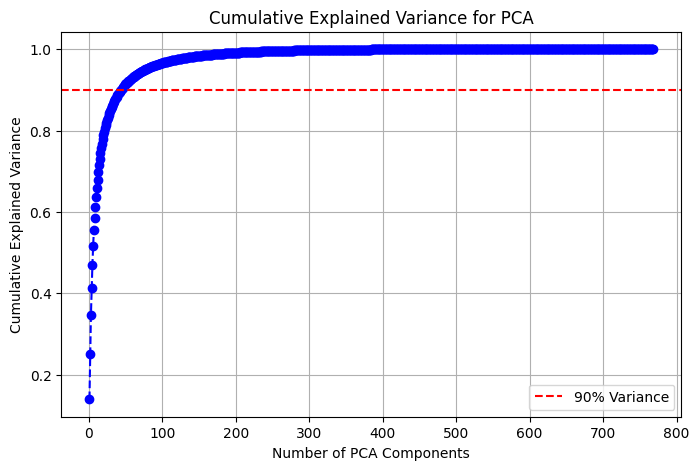

Optimal number of PCA components: 44
Optimal number of clusters from Knee Method: 8


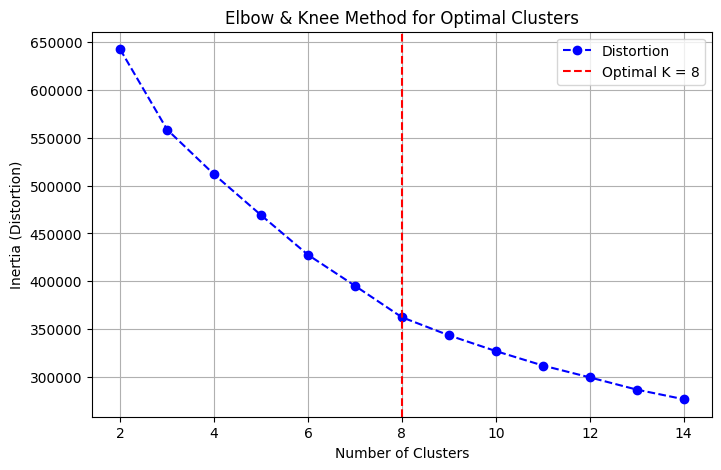

Silhouette Score: 0.36


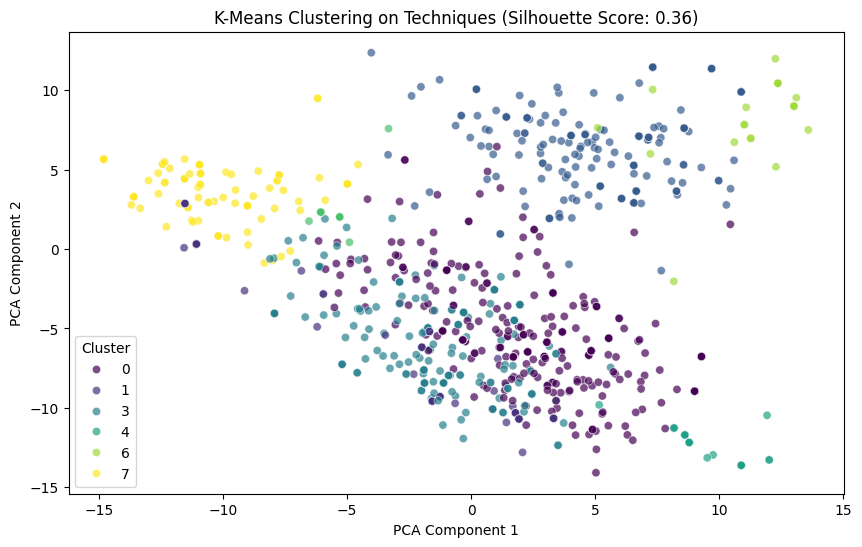

Clustered techniques saved as 'clustered_techniques.csv'.
                                            Technique  \
0                             Start the Day Mindfully   
1                                      Mindful Eating   
2                                     Mindful Walking   
3                                      Mindful Eating   
4                                     Mindful Walking   
5                                 Breathing Exercises   
6   Incorporate Mindful Breathing into Daily Activ...   
7                           4-7-8 Breathing Technique   
8                                   Somatic Awareness   
9                                Body Scan Meditation   
10                               Grounding Techniques   
11                          Prioritize Rest and Sleep   
12                             Mindfulness Meditation   
13                Progressive Muscle Relaxation (PMR)   
14                        Take Regular Mindful Breaks   
15                            

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load dataset
file_path = "simulation_results.csv"  # Update the path to your file
data = pd.read_csv(file_path)

# Drop null techniques and reset index
data = data.dropna(subset=['Technique']).reset_index(drop=True)

# Enhanced preprocessing: Lemmatization and removal of low-information words
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

print("Preprocessing techniques...")
data['Cleaned_Technique'] = data['Technique'].apply(preprocess_text)

# Load DistilBERT sentence transformer model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Convert techniques to embeddings
print("Generating text embeddings...")
embeddings = model.encode(data['Cleaned_Technique'].tolist(), show_progress_bar=True)

# Scale embeddings using RobustScaler to handle outliers
scaler = RobustScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Step 1: Determine optimal number of PCA components (Cumulative Explained Variance)
pca_full = PCA().fit(scaled_embeddings)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance for PCA")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.legend()
plt.grid()
plt.show()

# Select n_components where 90% variance is retained
n_components = np.argmax(explained_variance >= 0.90) + 1
print(f"Optimal number of PCA components: {n_components}")

# Step 2: Apply PCA with optimal components
pca = PCA(n_components=n_components, random_state=42)
pca_embeddings = pca.fit_transform(scaled_embeddings)

# Step 3: Determine optimal number of clusters using the Elbow & Knee Method
distortions = []
K_range = range(2, 15)  # Test between 2 and 15 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_embeddings)
    distortions.append(kmeans.inertia_)

# Find the optimal k using the Knee Method
knee_locator = KneeLocator(K_range, distortions, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee
print(f"Optimal number of clusters from Knee Method: {optimal_clusters}")

# Plot the elbow & knee method
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o', linestyle='--', color='b', label="Distortion")
plt.axvline(x=optimal_clusters, color='r', linestyle='--', label=f"Optimal K = {optimal_clusters}")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow & Knee Method for Optimal Clusters")
plt.legend()
plt.grid()
plt.show()

# Step 4: Apply K-Means Clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(pca_embeddings)

# Compute silhouette score
silhouette_avg = silhouette_score(pca_embeddings, data['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Step 5: Visualize clusters using PCA-reduced 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=data['Cluster'], palette='viridis', alpha=0.7)
plt.title(f"K-Means Clustering on Techniques (Silhouette Score: {silhouette_avg:.2f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Step 6: Save and Display the Clustered Techniques
data.to_csv("clustered_techniques.csv", index=False)
print("Clustered techniques saved as 'clustered_techniques.csv'.")
print(data[['Technique', 'Cleaned_Technique', 'Cluster']].head(20))  # Display the first 20 rows


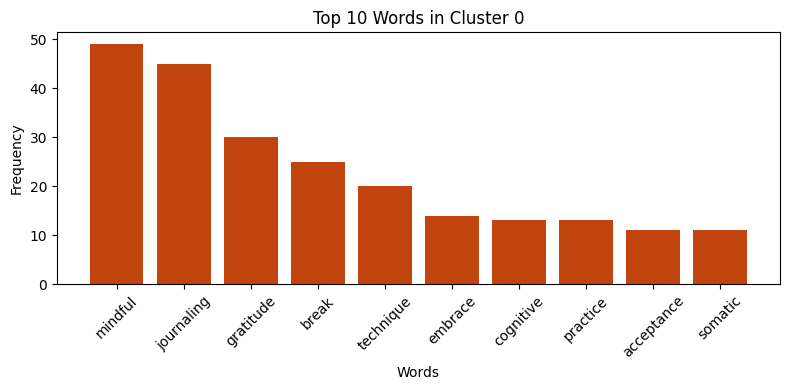

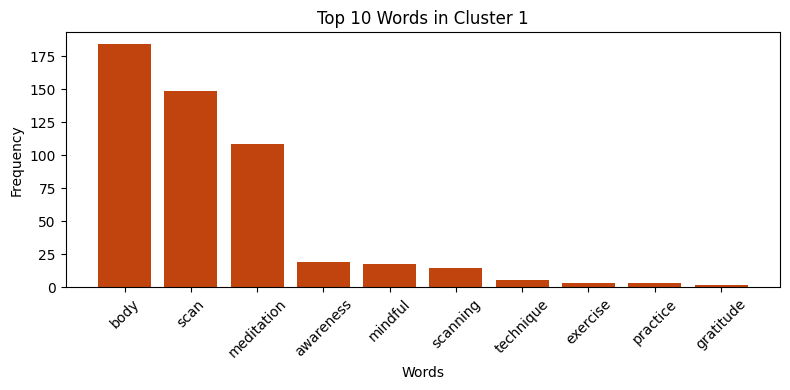

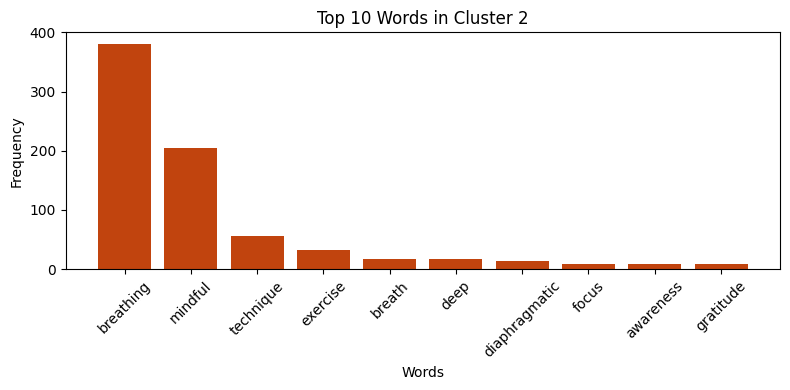

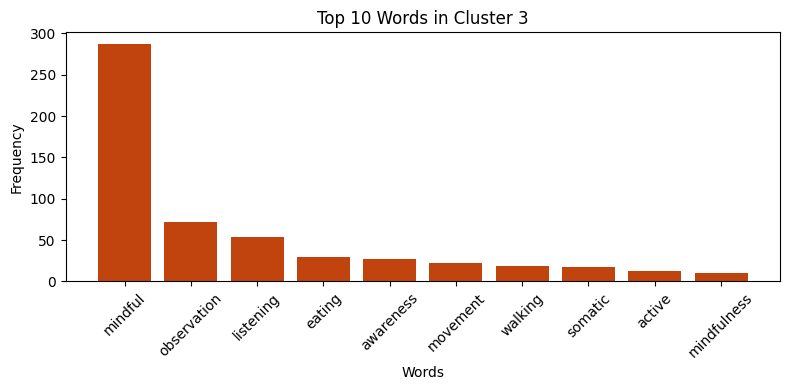

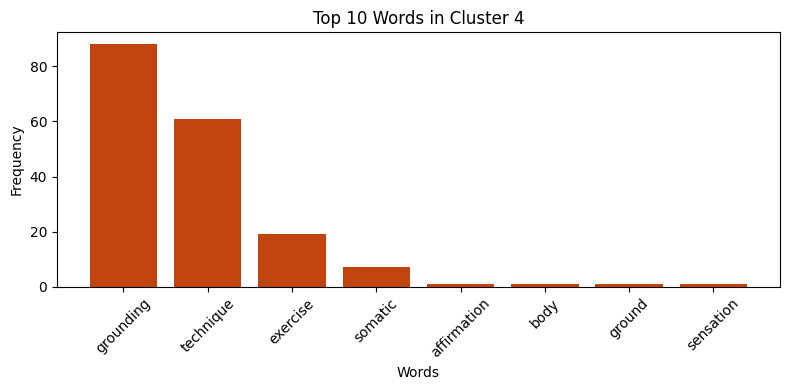

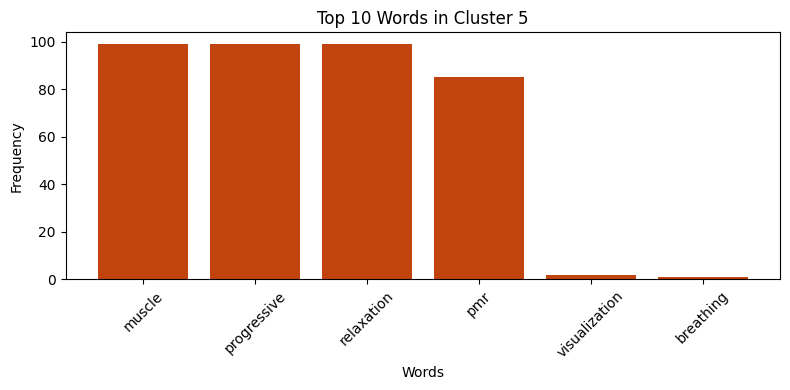

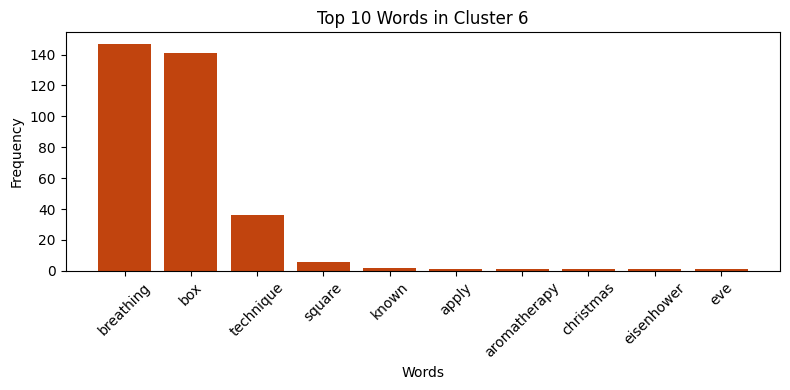

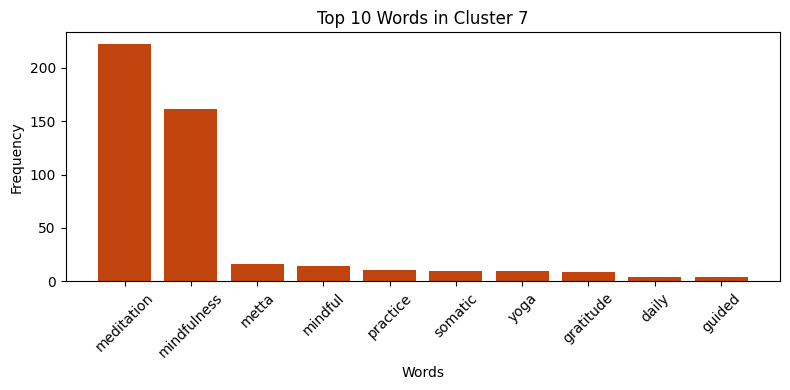


Cluster Themes:
Cluster 0: mindful, journaling, gratitude, break, technique, embrace, cognitive, practice, acceptance, somatic
Cluster 1: body, scan, meditation, awareness, mindful, scanning, technique, exercise, practice, gratitude
Cluster 2: breathing, mindful, technique, exercise, breath, deep, diaphragmatic, focus, awareness, gratitude
Cluster 3: mindful, observation, listening, eating, awareness, movement, walking, somatic, active, mindfulness
Cluster 4: grounding, technique, exercise, somatic, affirmation, body, ground, sensation
Cluster 5: muscle, progressive, relaxation, pmr, visualization, breathing
Cluster 6: breathing, box, technique, square, known, apply, aromatherapy, christmas, eisenhower, eve
Cluster 7: meditation, mindfulness, metta, mindful, practice, somatic, yoga, gratitude, daily, guided


In [3]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def extract_and_visualize_cluster_themes(data, text_column="Cleaned_Technique", cluster_column="Cluster", top_n=10):
    themes = {}
    vectorizer = CountVectorizer(stop_words="english")  # Vectorizer for text

    for cluster in sorted(data[cluster_column].unique()):
        # Filter rows for the current cluster
        cluster_data = data[data[cluster_column] == cluster][text_column]
        
        # Combine all text in the cluster into a single string
        combined_text = " ".join(cluster_data)
        
        # Vectorize the text to get word counts
        word_counts = vectorizer.fit_transform([combined_text])
        words = vectorizer.get_feature_names_out()
        counts = word_counts.toarray().flatten()
        
        # Create a dictionary of word frequencies
        cluster_word_counts = dict(zip(words, counts))
        
        # Sort words by their counts and select the top N
        sorted_word_counts = sorted(cluster_word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Save the top words for the cluster
        themes[cluster] = [word for word, count in sorted_word_counts]
        
        # Unzip the sorted counts into two lists: words and counts
        words, counts = zip(*sorted_word_counts)
        
        # Plot the top words for the cluster
        plt.figure(figsize=(8, 4))
        plt.bar(words, counts, color="#C1440E")
        plt.title(f"Top {top_n} Words in Cluster {cluster}")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return themes

# Extract themes from clusters and visualize them
themes = extract_and_visualize_cluster_themes(data, text_column="Cleaned_Technique", cluster_column="Cluster", top_n=10)

# Print the themes
print("\nCluster Themes:")
for cluster, top_words in themes.items():
    print(f"Cluster {cluster}: {', '.join(top_words)}")

Applying DBSCAN...
Number of clusters found: 47
Silhouette Score: 0.53


C:\Users\anacs\AppData\Local\Temp\ipykernel_35944\2272354341.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Cluster', palette='viridis')


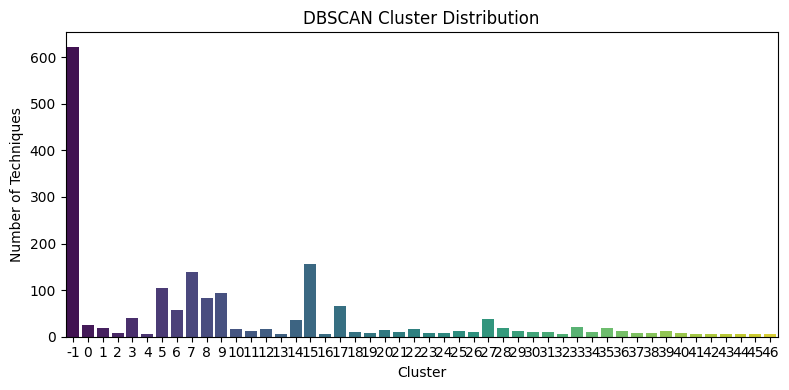

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Apply DBSCAN
print("Applying DBSCAN...")
dbscan = DBSCAN(eps=1.5, min_samples=5, metric="euclidean")
data['Cluster'] = dbscan.fit_predict(pca_embeddings)

# Check the number of clusters found
num_clusters = len(set(data['Cluster']) - {-1})  # -1 is for noise
print(f"Number of clusters found: {num_clusters}")

# Compute silhouette score (if there are more than 1 cluster)
if num_clusters > 1:
    silhouette_avg = silhouette_score(pca_embeddings, data['Cluster'])
    print(f"Silhouette Score: {silhouette_avg:.2f}")
else:
    print("Silhouette Score cannot be computed (only one cluster found).")

# Visualize cluster distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='Cluster', palette='viridis')
plt.title("DBSCAN Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Techniques")
plt.tight_layout()
plt.show()

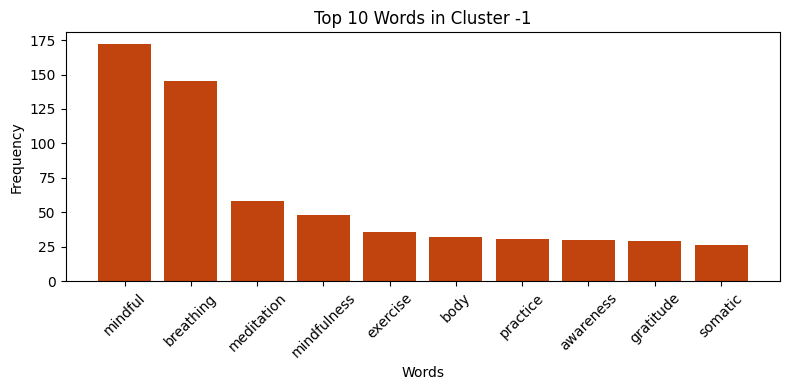

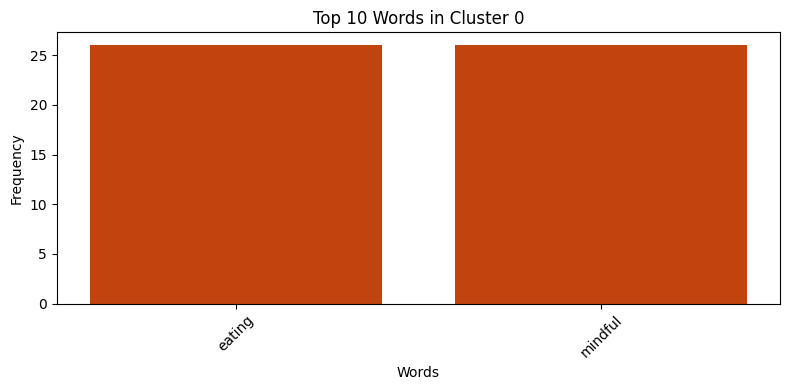

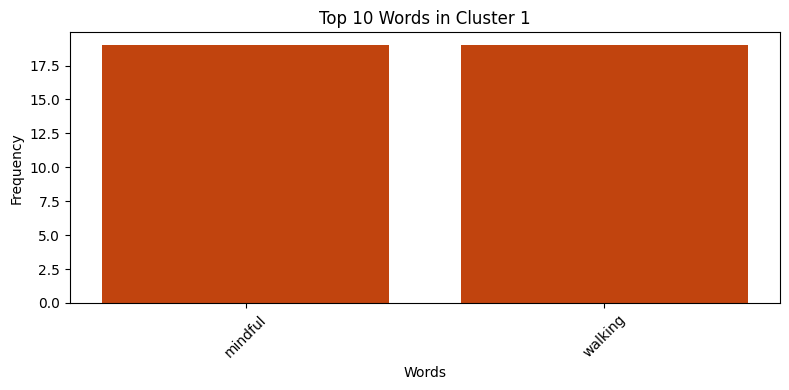

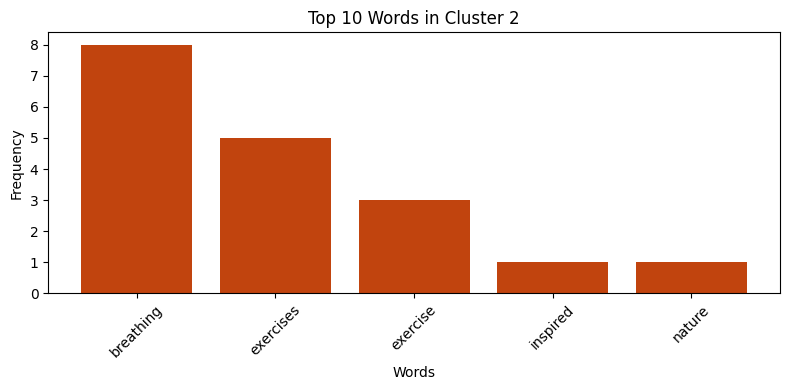

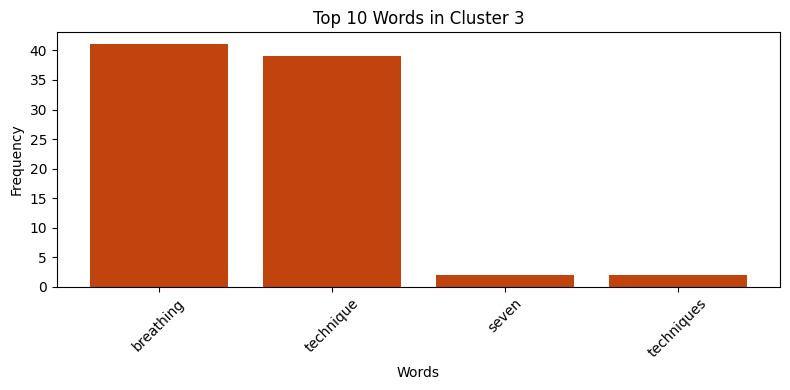

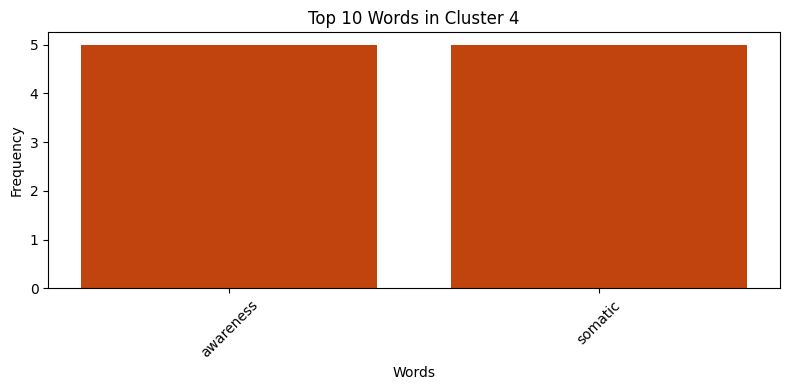

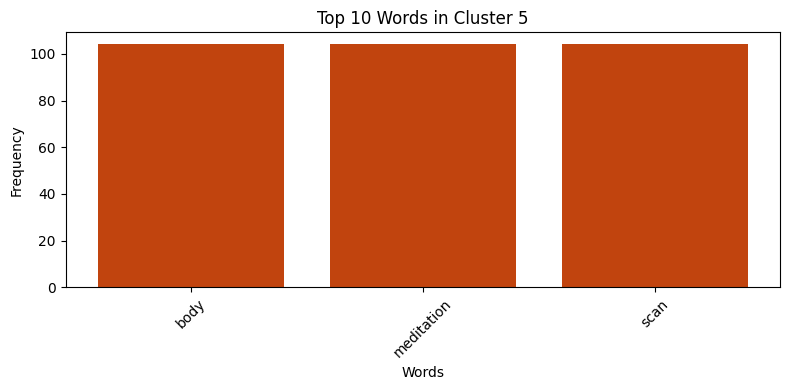

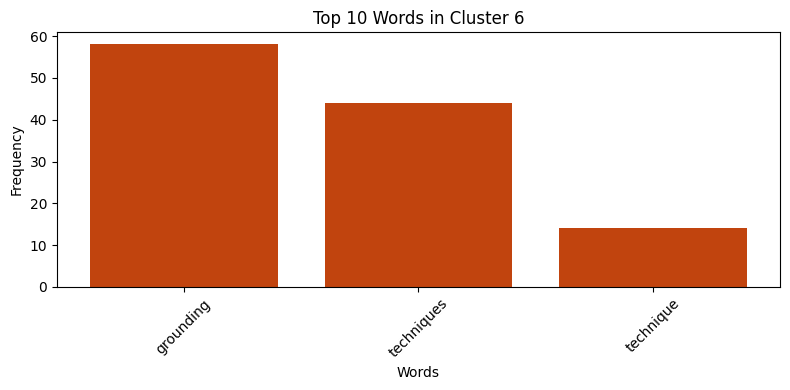

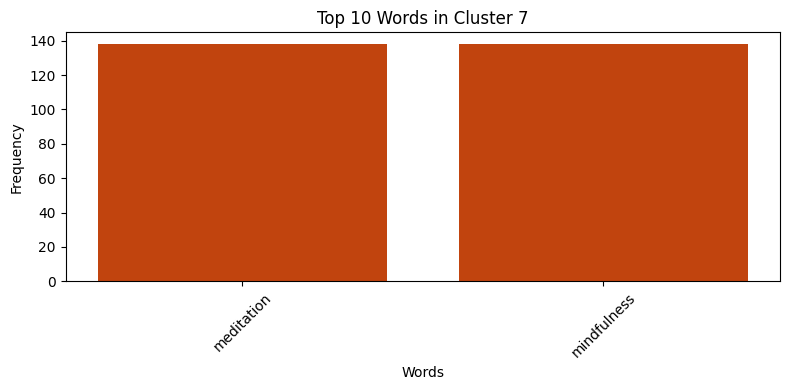

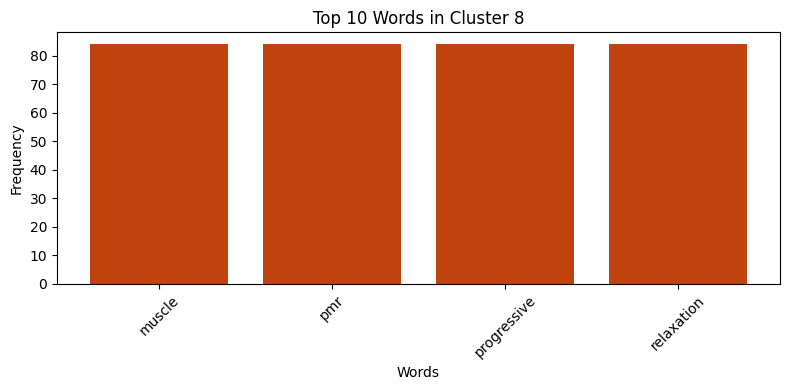

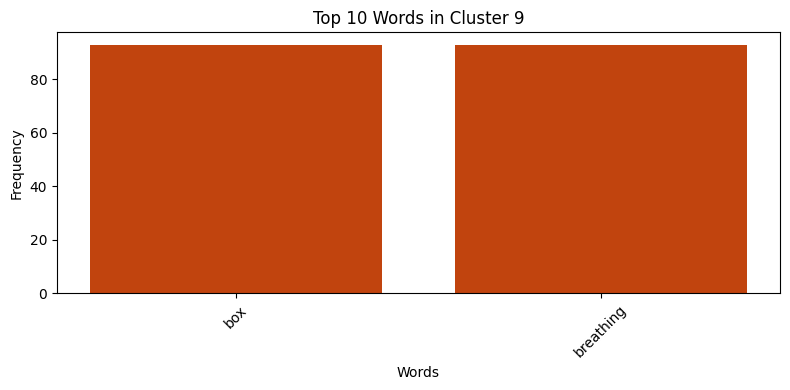

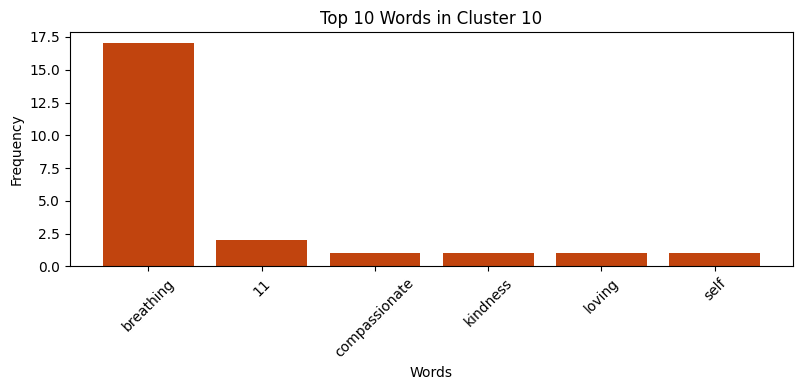

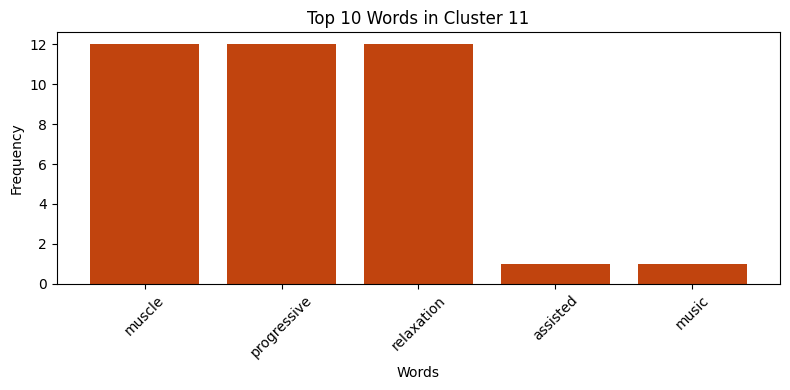

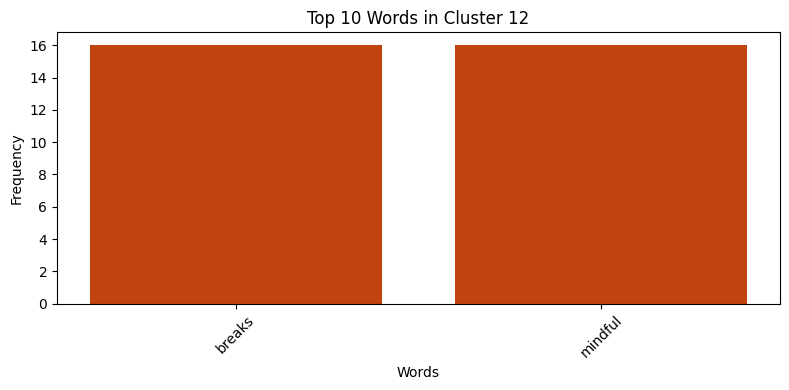

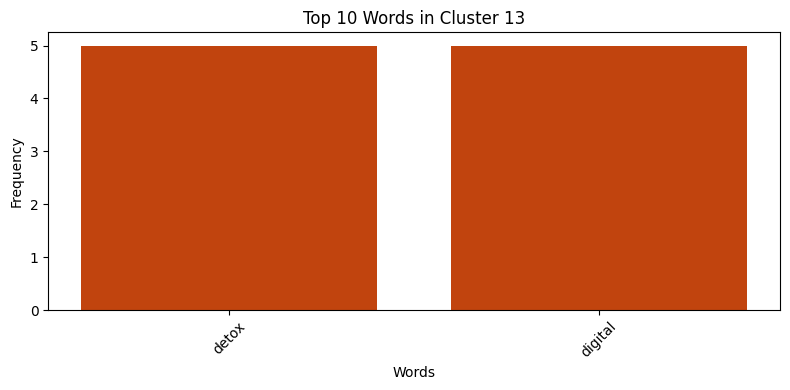

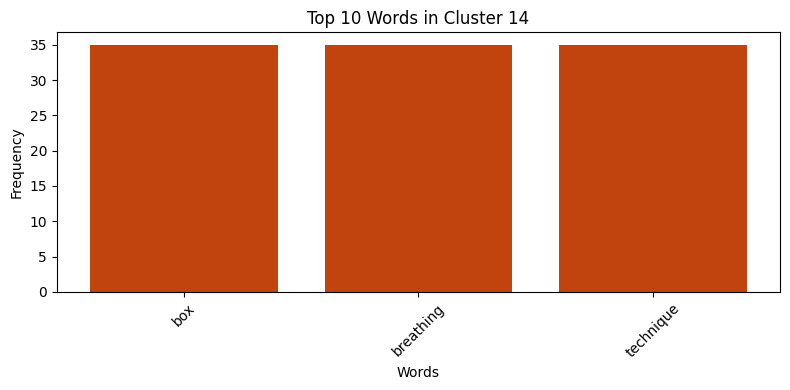

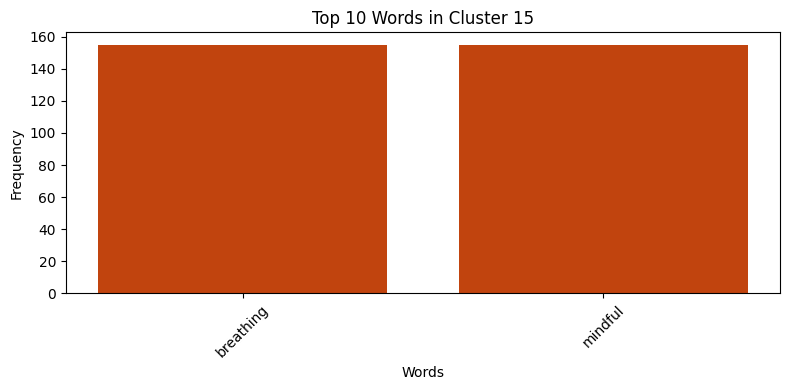

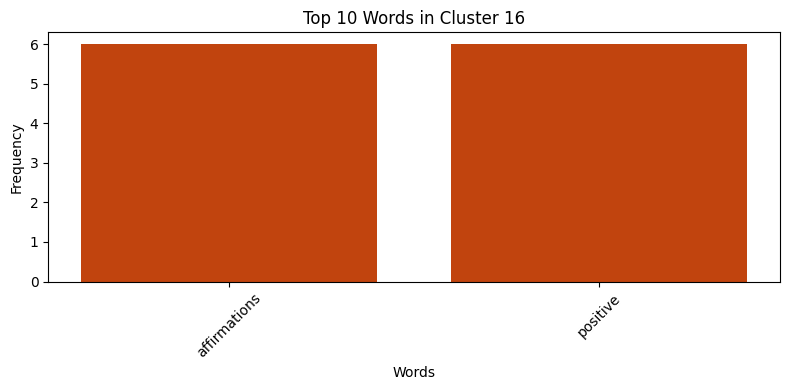

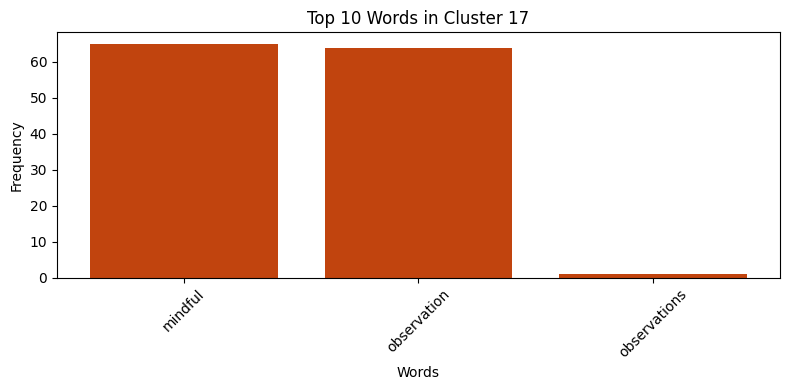

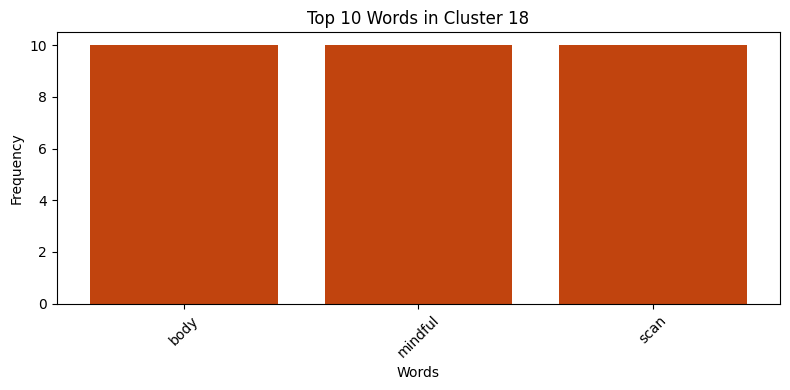

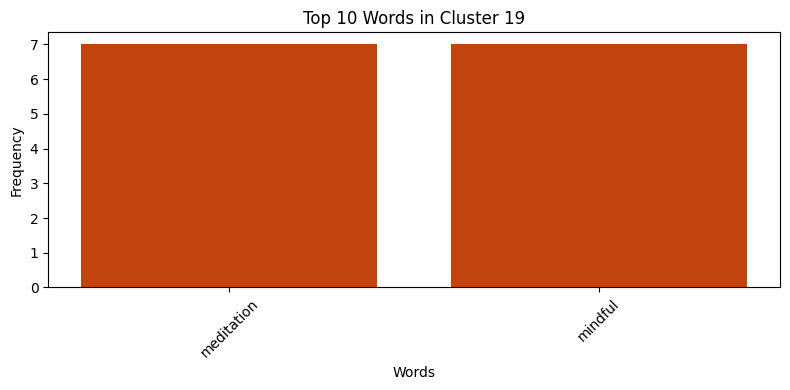

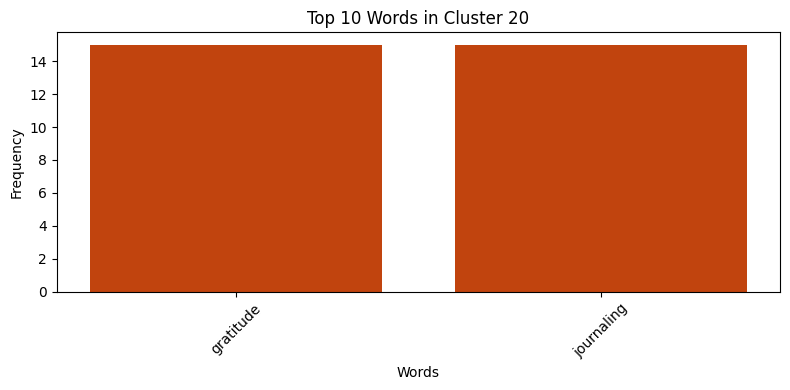

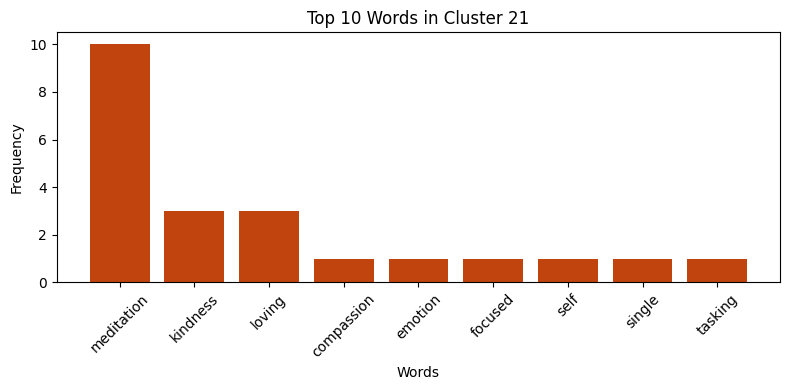

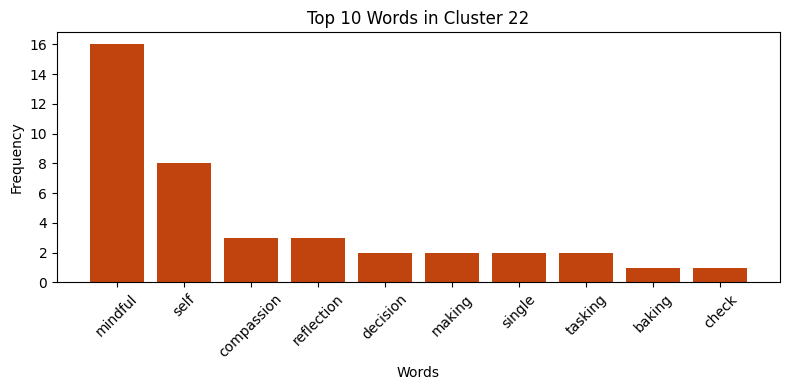

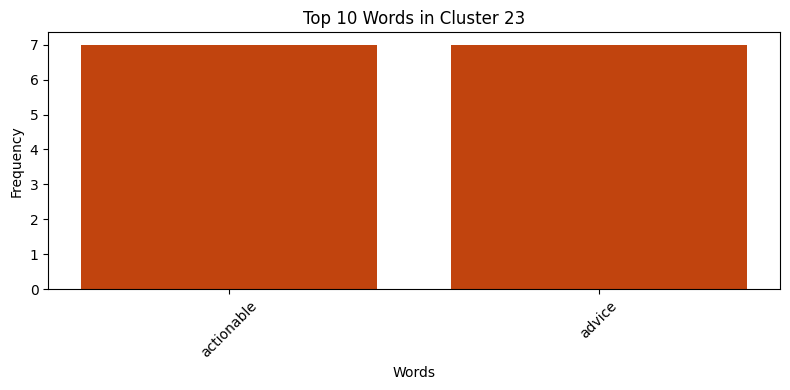

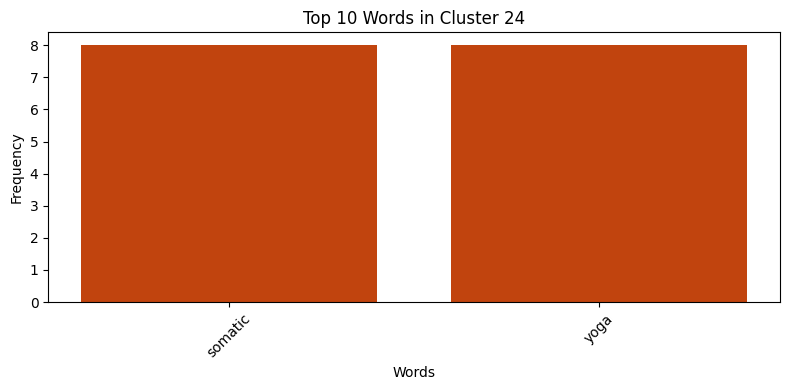

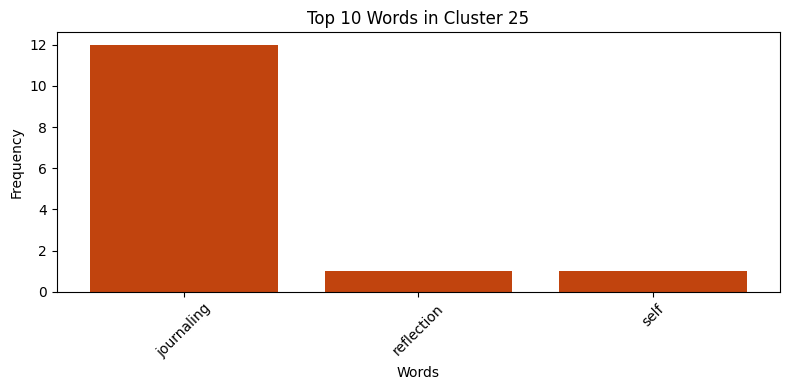

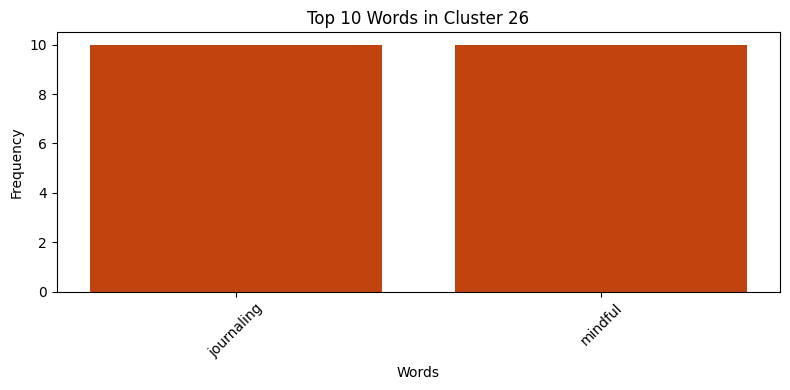

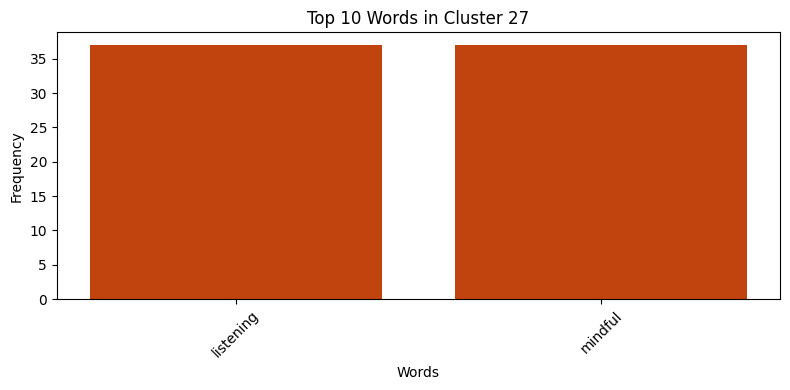

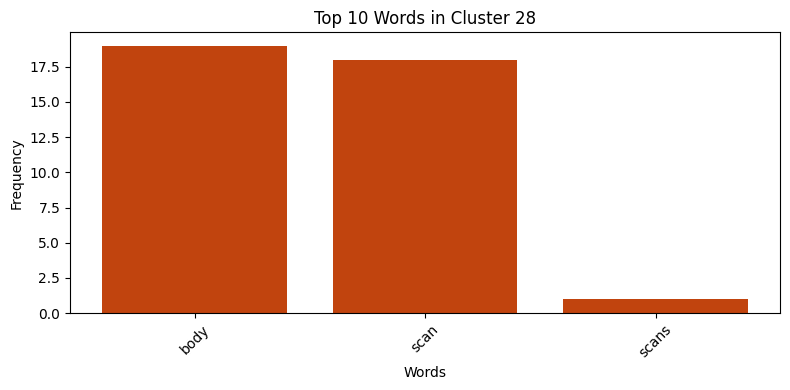

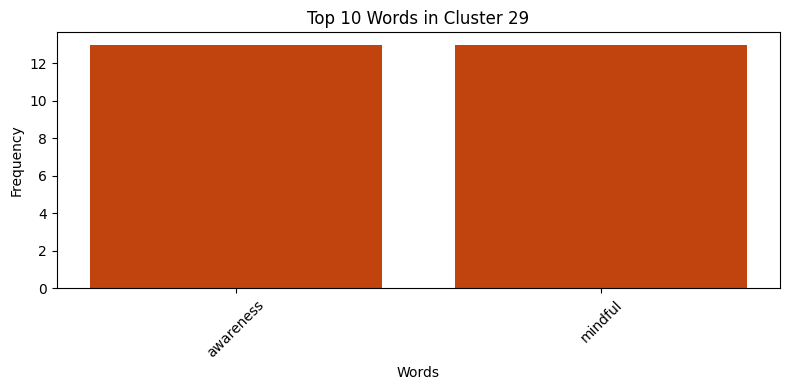

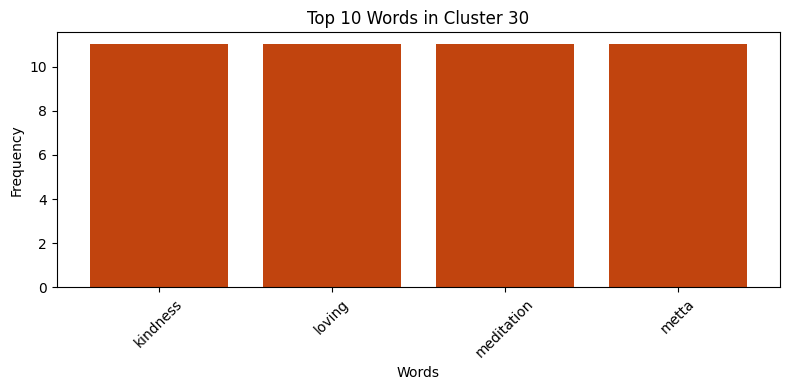

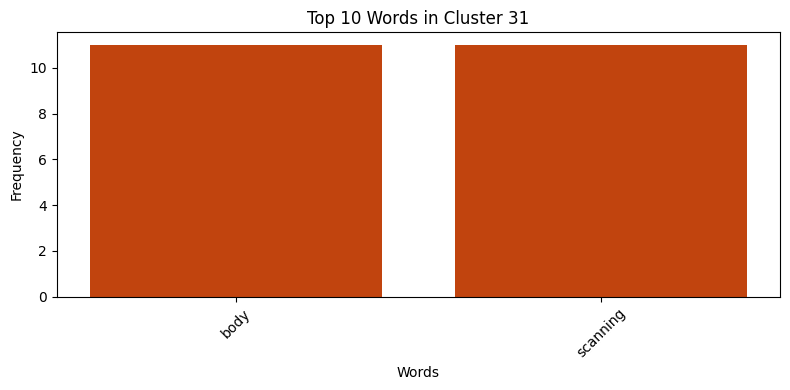

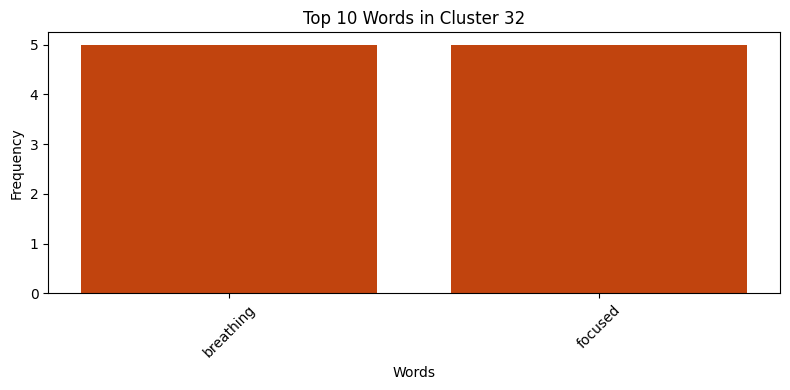

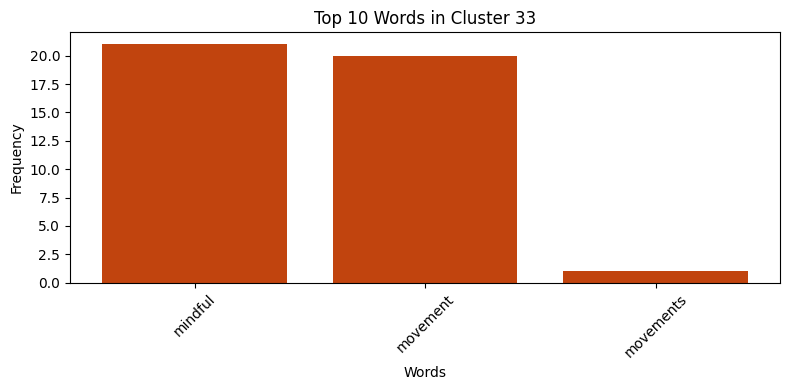

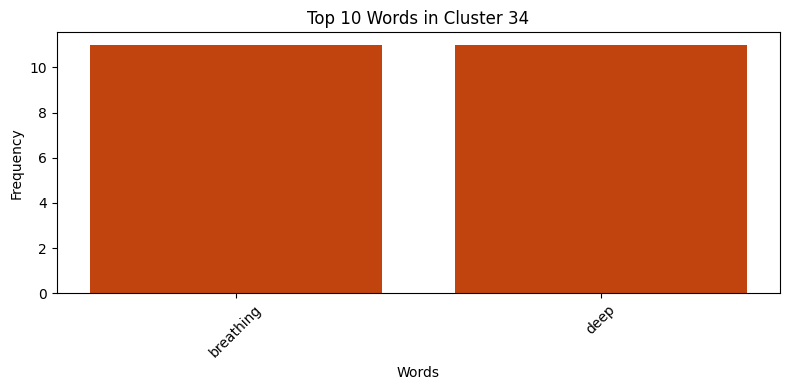

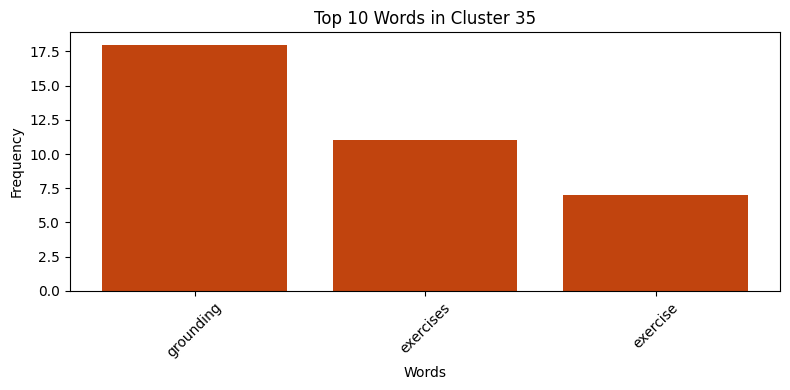

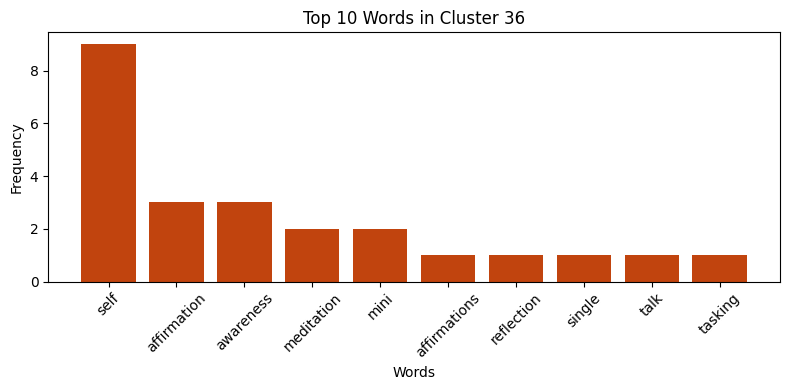

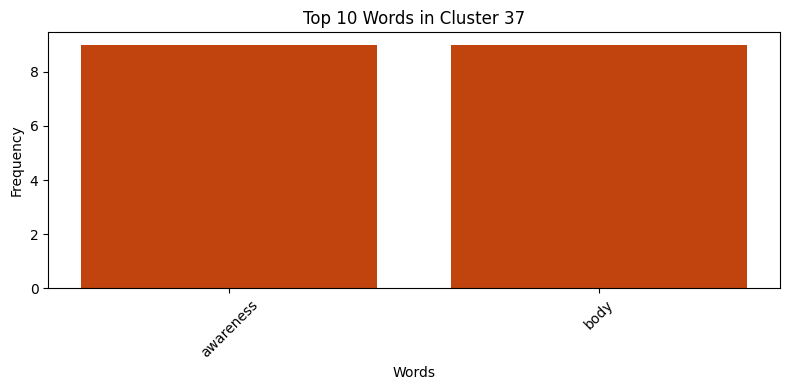

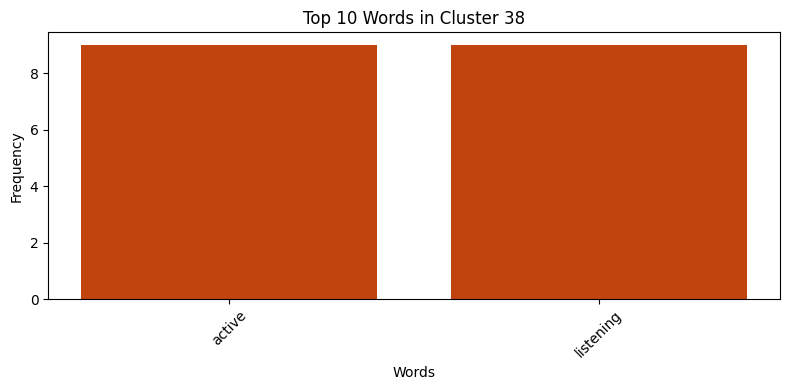

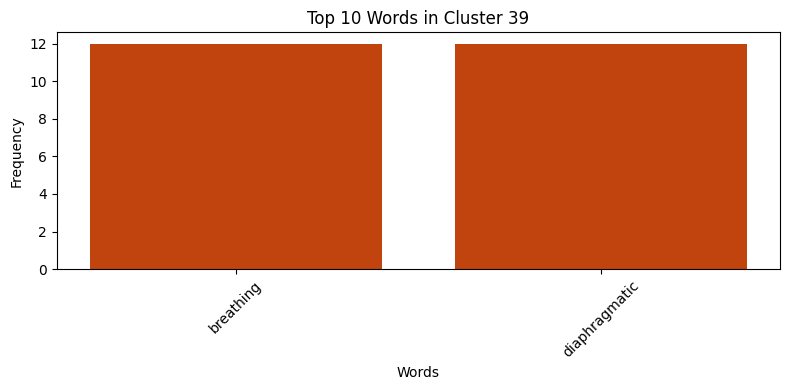

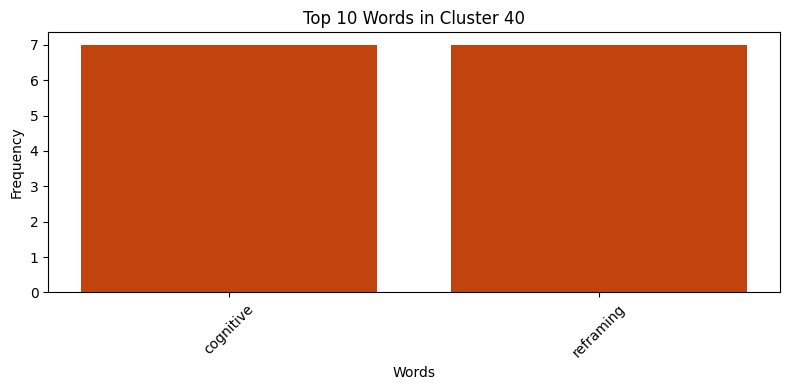

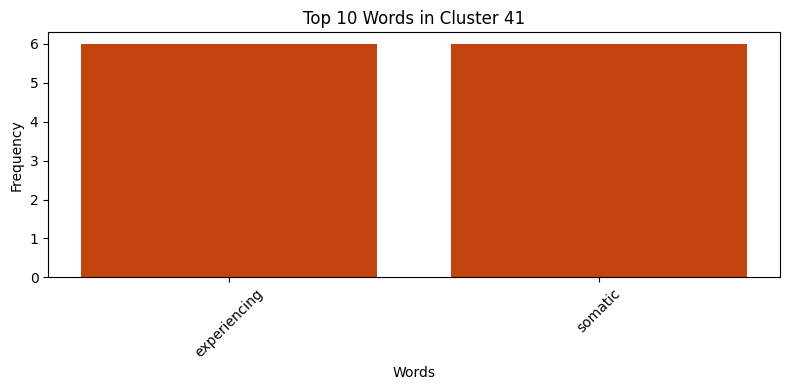

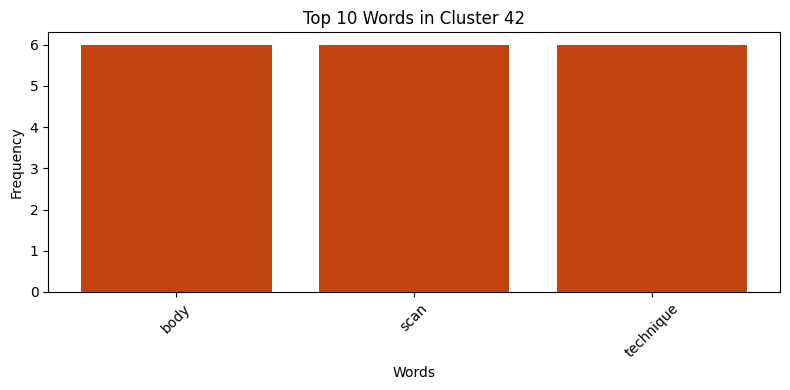

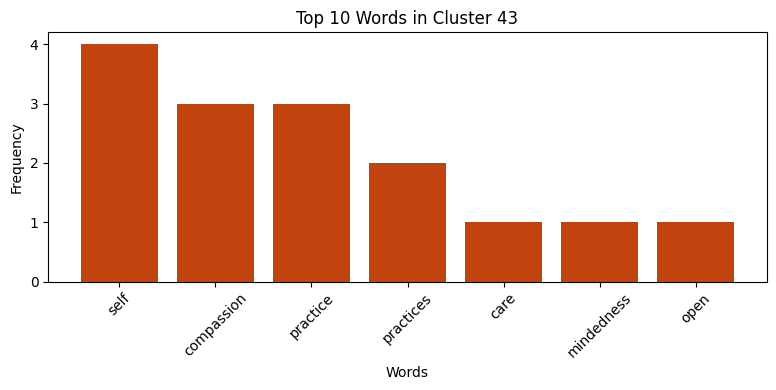

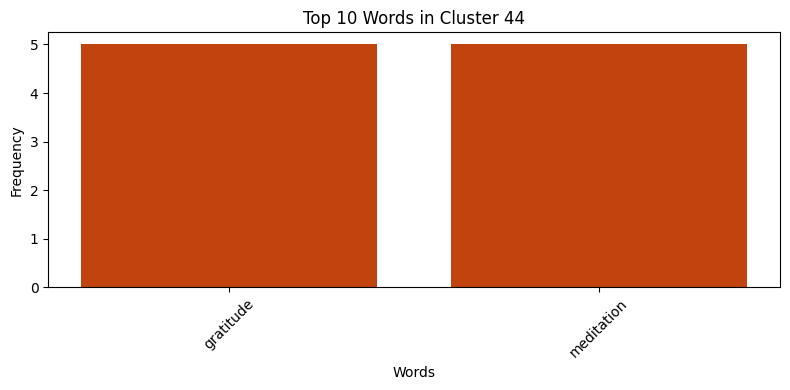

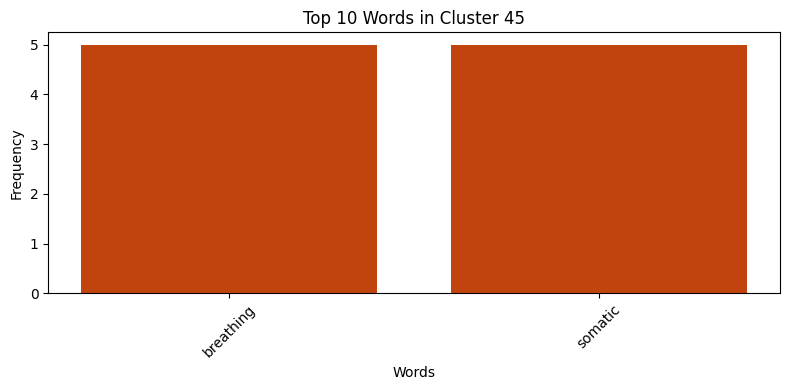

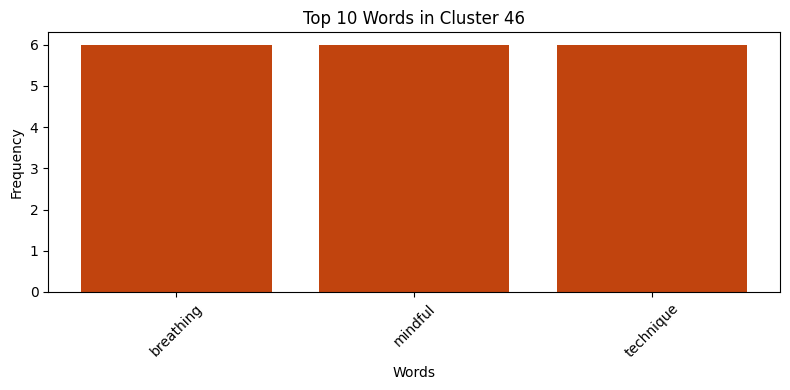

In [14]:
# Extract themes from clusters
themes = extract_cluster_themes(data, text_column="Technique", cluster_column="Cluster", top_n=10)

Cluster Sizes:
 Cluster
-1     622
 15    155
 7     138
 5     104
 9      93
 8      84
 17     65
 6      58
 3      41
 27     37
 14     35
 0      26
 33     21
 28     19
 1      19
 35     18
 10     17
 22     16
 12     16
 20     15
 29     13
 25     12
 39     12
 11     12
 36     12
 30     11
 31     11
 34     11
 21     10
 18     10
 26     10
 37      9
 38      9
 24      8
 2       8
 40      7
 23      7
 19      7
 16      6
 41      6
 42      6
 46      6
 32      5
 13      5
 4       5
 43      5
 44      5
 45      5
Name: count, dtype: int64


C:\Users\anacs\AppData\Local\Temp\ipykernel_35944\3825263449.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette="viridis")


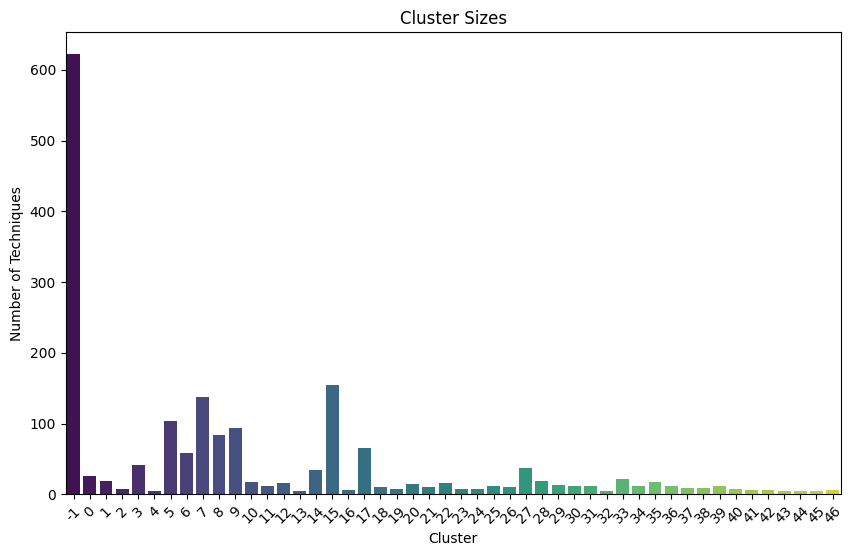

In [15]:
# Analyze cluster sizes
cluster_sizes = data['Cluster'].value_counts()
print("Cluster Sizes:\n", cluster_sizes)

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette="viridis")
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Techniques")
plt.xticks(rotation=45)
plt.show()

In [16]:
# Combine small clusters into "Other"
threshold = 10  # Minimum size for a cluster to be considered valid
data['Cluster'] = data['Cluster'].apply(lambda x: x if cluster_sizes[x] >= threshold else -2)  # -2 for "Other"

# Recalculate cluster sizes
cluster_sizes = data['Cluster'].value_counts()
print("Updated Cluster Sizes:\n", cluster_sizes)

Updated Cluster Sizes:
 Cluster
-1     622
 15    155
 7     138
-2     109
 5     104
 9      93
 8      84
 17     65
 6      58
 3      41
 27     37
 14     35
 0      26
 33     21
 28     19
 1      19
 35     18
 10     17
 12     16
 22     16
 20     15
 29     13
 36     12
 39     12
 25     12
 11     12
 30     11
 31     11
 34     11
 26     10
 21     10
 18     10
Name: count, dtype: int64


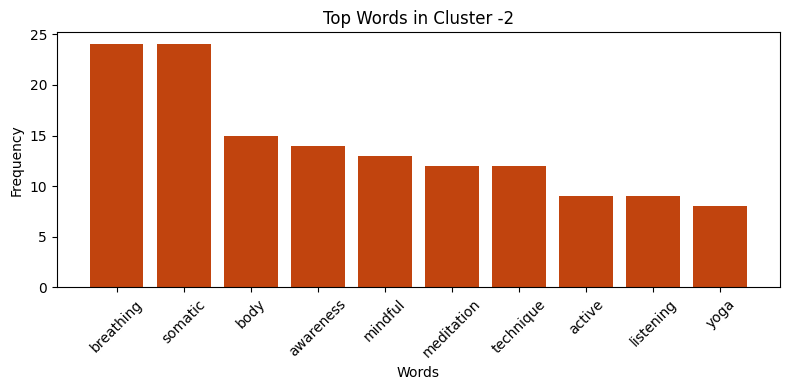

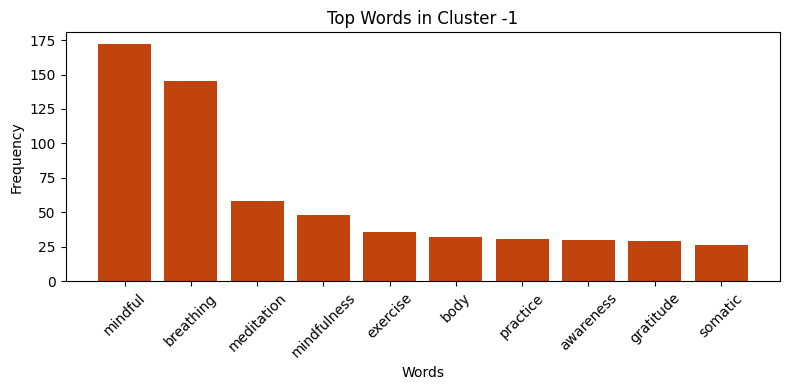

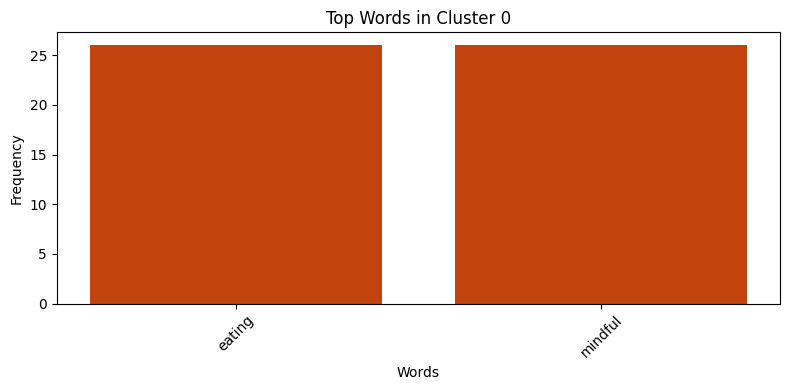

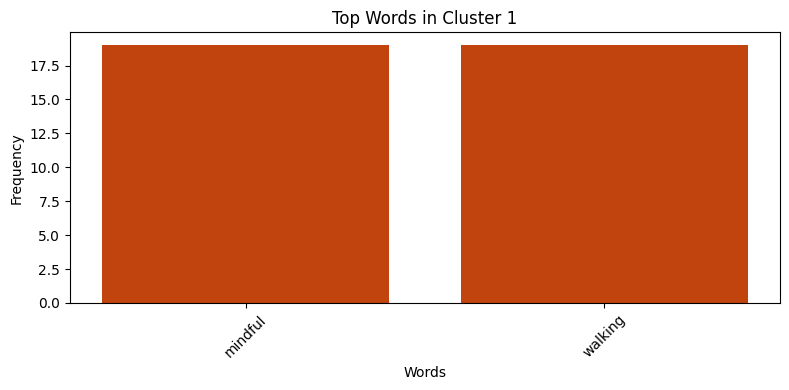

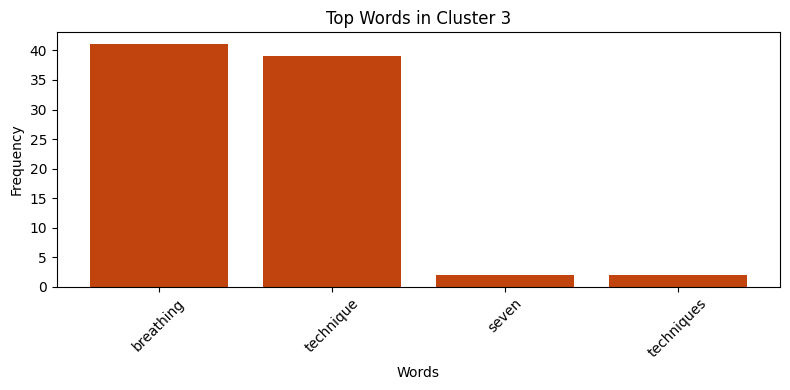

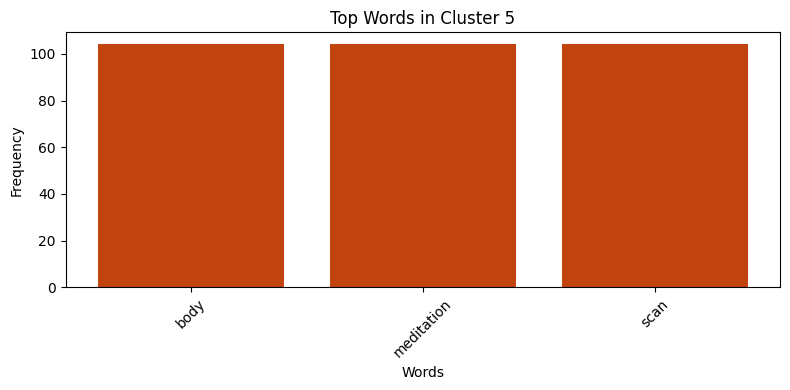

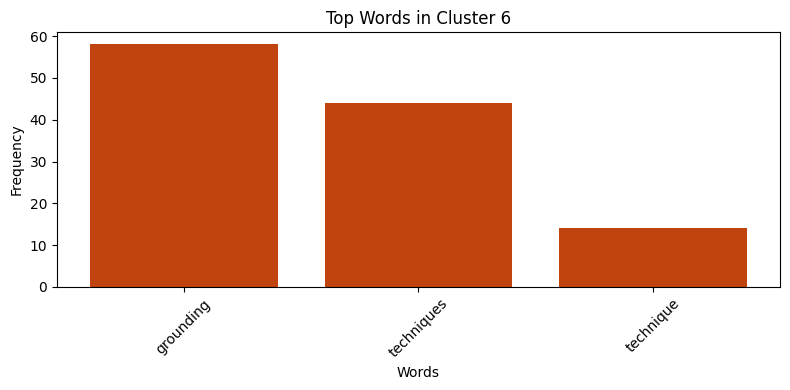

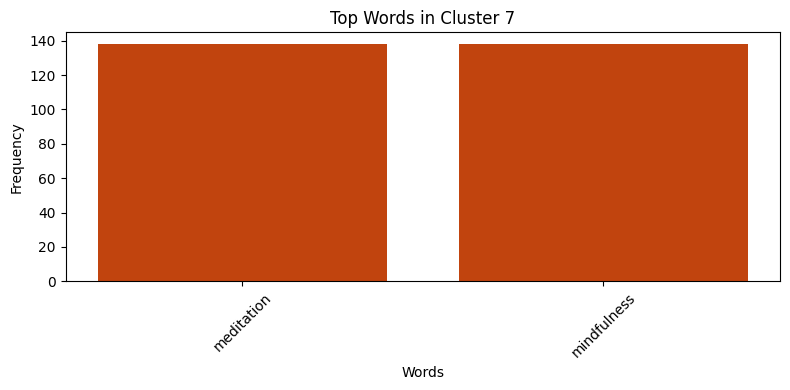

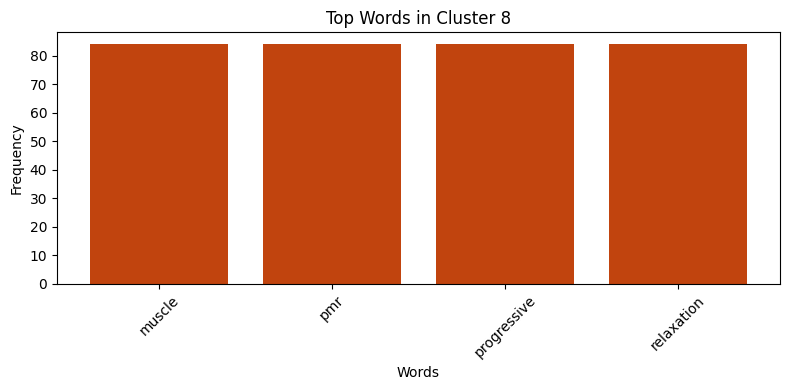

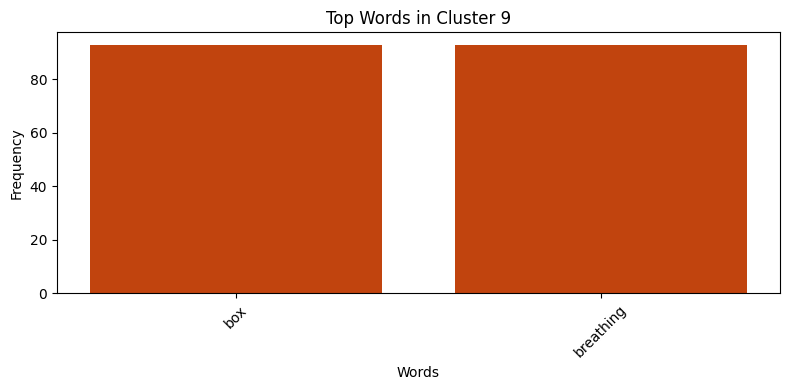

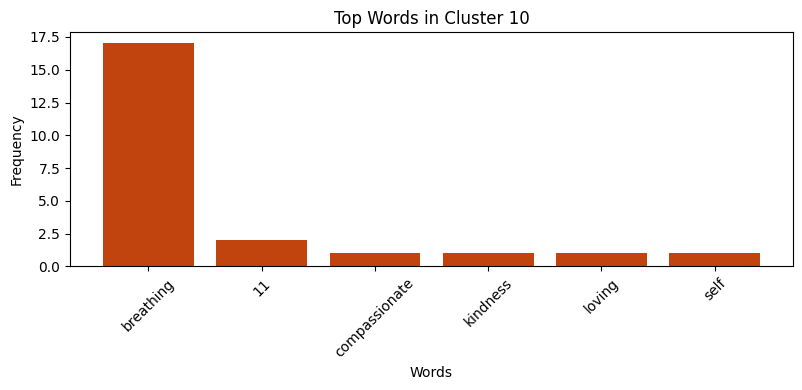

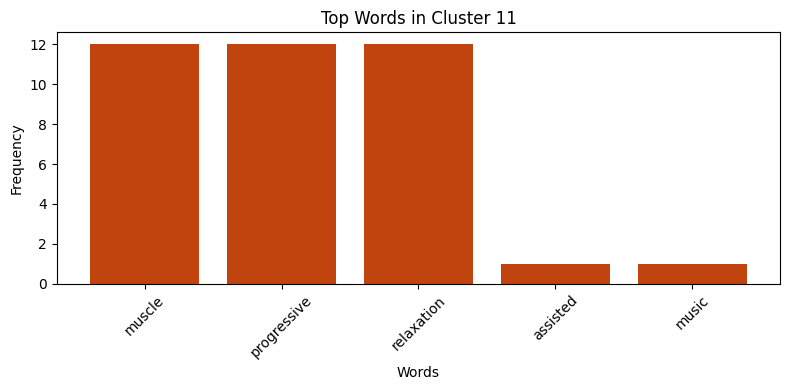

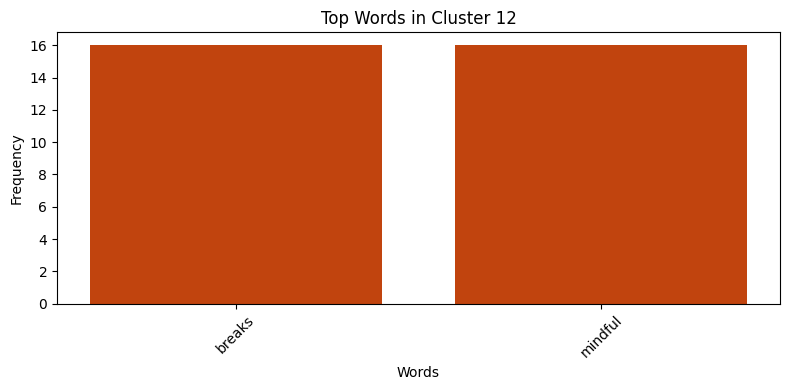

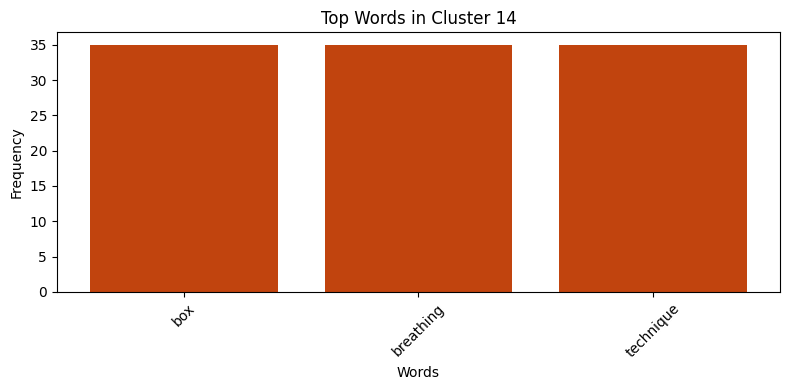

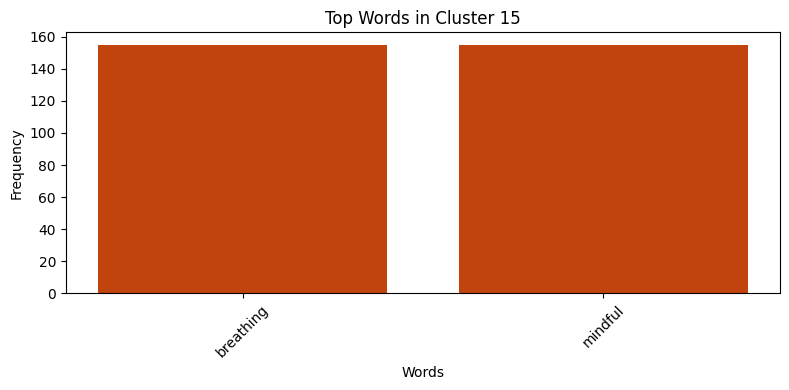

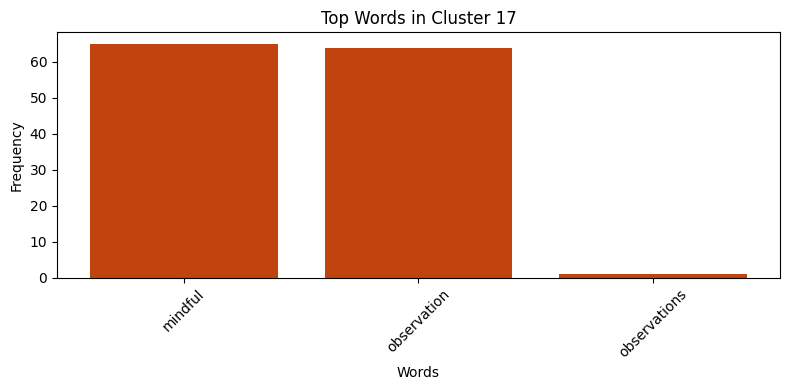

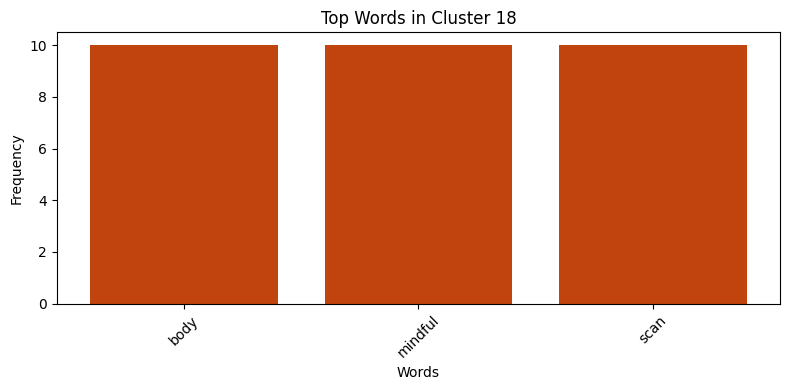

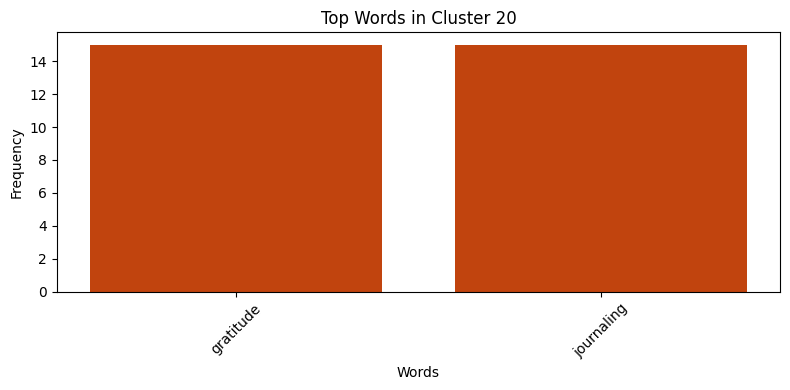

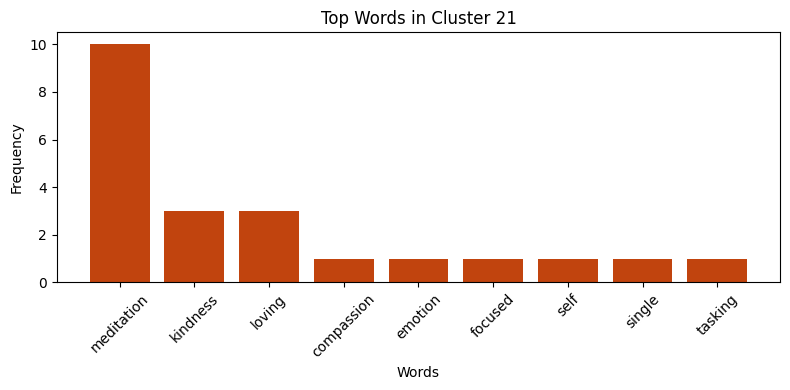

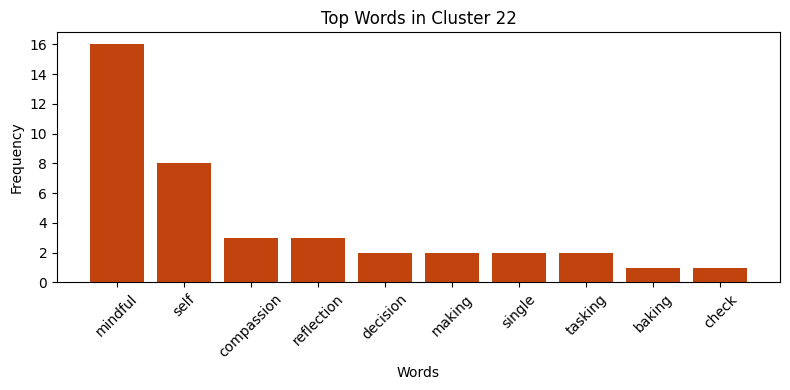

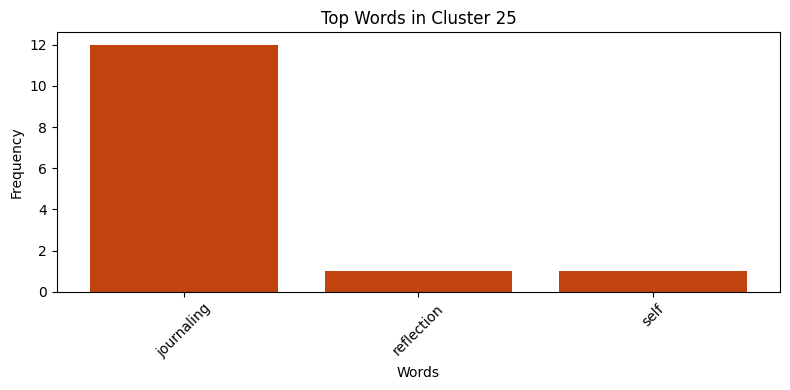

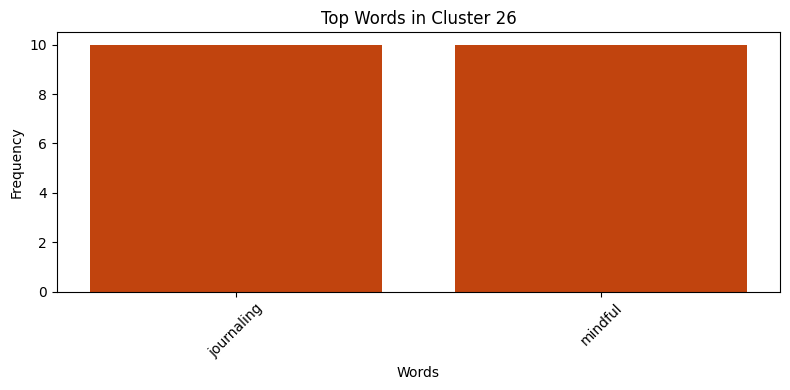

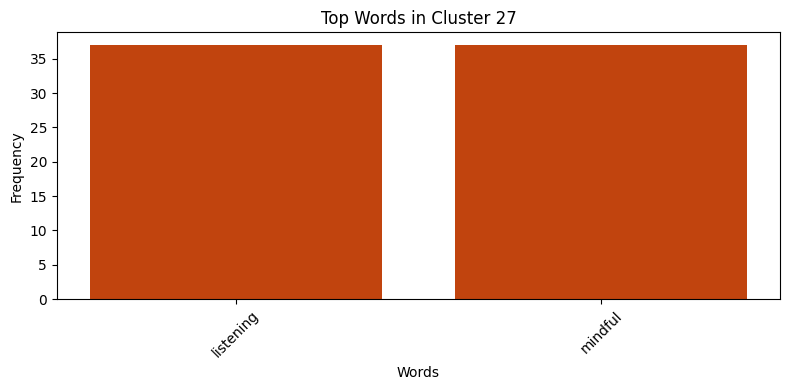

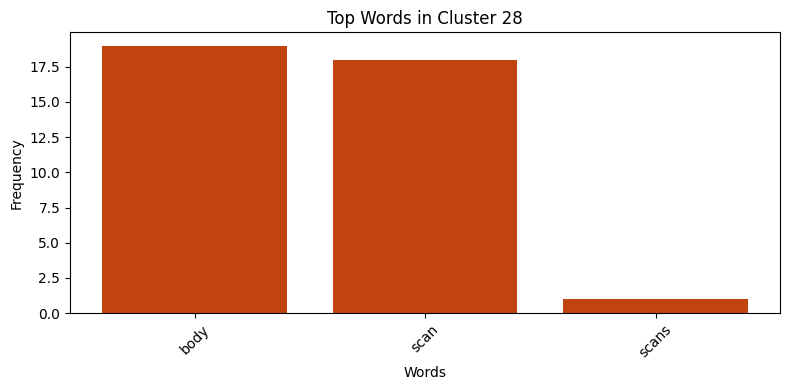

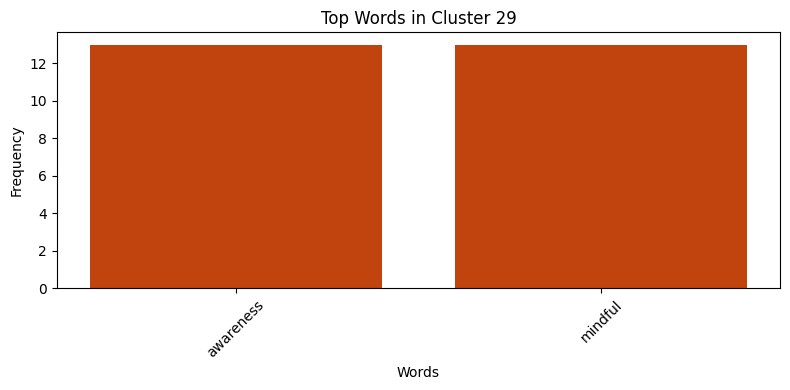

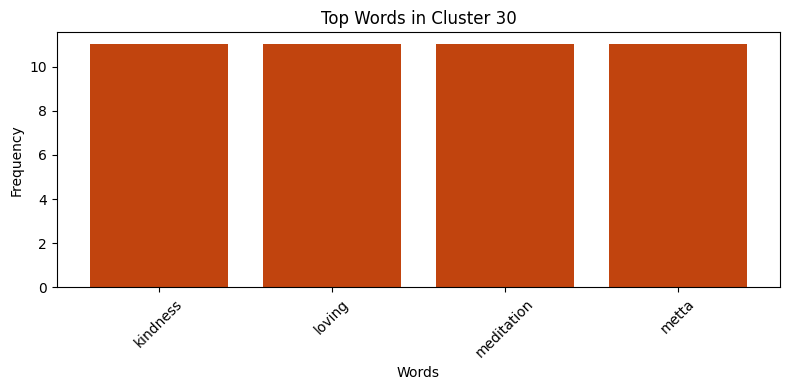

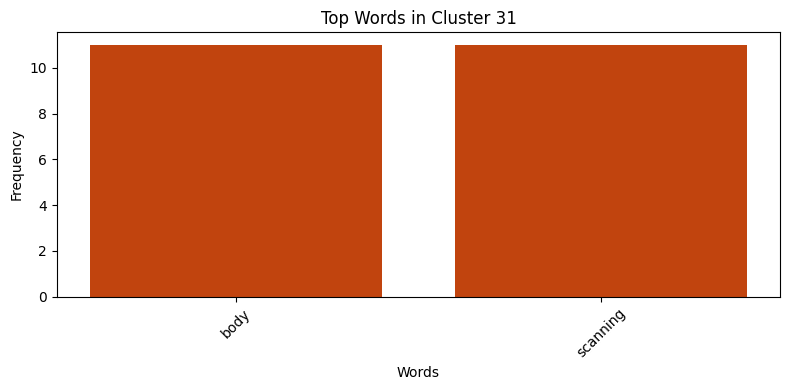

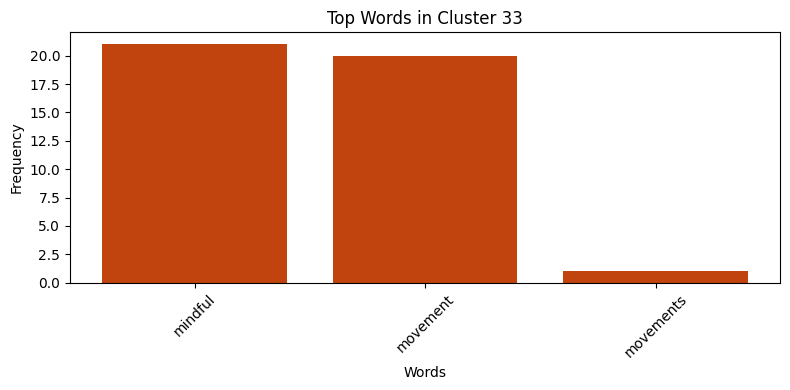

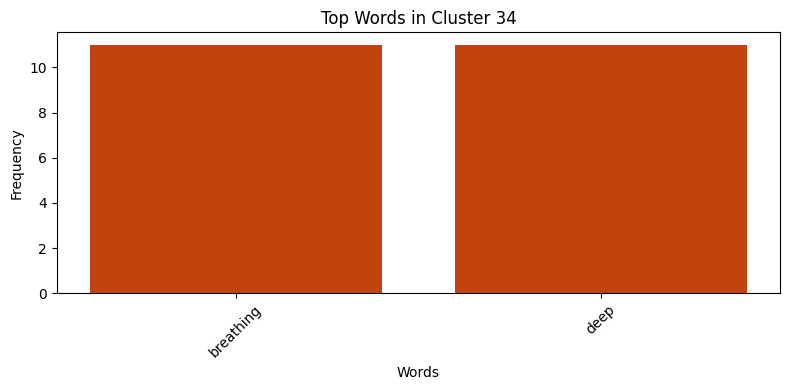

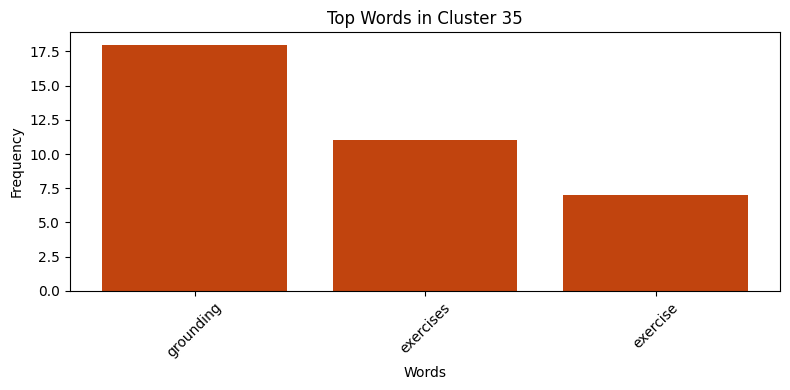

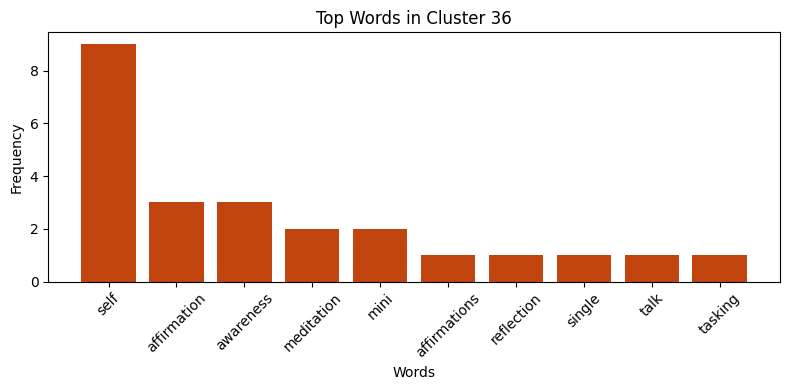

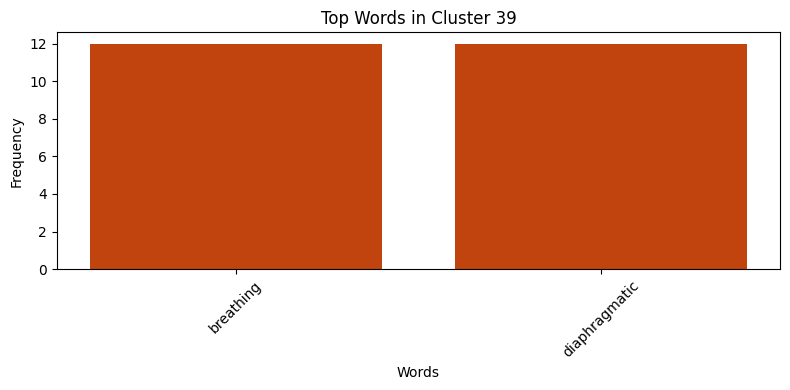

In [18]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def extract_and_plot_cluster_themes(data, text_column="Technique", cluster_column="Cluster", top_n=10):
    themes = {}
    vectorizer = CountVectorizer(stop_words="english")

    for cluster in sorted(data[cluster_column].unique()):
        # Filter rows for the current cluster
        cluster_data = data[data[cluster_column] == cluster][text_column]
        
        if cluster_data.empty:
            continue  # Skip empty clusters

        # Combine all text in the cluster into a single string
        combined_text = " ".join(cluster_data)
        
        # Vectorize the text to get word counts
        word_counts = vectorizer.fit_transform([combined_text])
        words = vectorizer.get_feature_names_out()
        counts = word_counts.toarray().flatten()
        
        # Create a dictionary of word frequencies
        cluster_word_counts = dict(zip(words, counts))
        
        # Sort words by their counts and select the top N
        sorted_word_counts = sorted(cluster_word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Save the top words for the cluster
        themes[cluster] = [word for word, count in sorted_word_counts]
        
        # Unzip the sorted counts into two lists: words and counts
        words, counts = zip(*sorted_word_counts)
        
        # Plot the top N words
        plt.figure(figsize=(8, 4))
        plt.bar(words, counts, color="#C1440E")
        plt.title(f"Top Words in Cluster {cluster}")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return themes

# Extract and plot themes for updated clusters
themes = extract_and_plot_cluster_themes(data, text_column="Technique", cluster_column="Cluster", top_n=10)